In [161]:
# read the file 'dataset_reg_pair_filled.csv' and generate synthetic data
# first read the file, then make a list of the source training images
# then for each image, generate 10 synthetic images with random affine transformation

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import random
import csv
from PIL import Image
import shutil

import torch
import torchvision.transforms.functional as F
from PIL import Image

from utils.utils0 import tensor_affine_transform, transform_to_displacement_field
from utils.utils1 import transform_points_DVF, transform_points_from_DVF_unbatched, transform_points_from_DVF, plot_grid
from utils.SuperPoint import SuperPointFrontend, PointTracker
superpoint = SuperPointFrontend('utils/superpoint_v1.pth', nms_dist=4,
                          conf_thresh=0.015, nn_thresh=0.7, cuda=True)

# read the file
df = pd.read_csv('Dataset/dataset_reg_pair_filled.csv')
print(df.shape)
df.head()

(5040, 9)


,source,Source ROI,target,Target ROI,training,Warped target images,Warped target ROI,Execution time,Directory
0,2011248_20161215__L_b2.jpg,NaN,2011248_20161215__L_b1.jpg,NaN,1,NaN,NaN,NaN,Dataset/Dataset-processed/15-12-2559/2011248/Lb
1,2011248_20161215__L_b2.jpg,NaN,2011248_20161215__L_b3.jpg,NaN,1,NaN,NaN,NaN,Dataset/Dataset-processed/15-12-2559/2011248/Lb
2,2011248_20161215__L_b1.jpg,NaN,2011248_20161215__L_b3.jpg,NaN,1,NaN,NaN,NaN,Dataset/Dataset-processed/15-12-2559/2011248/Lb
3,2011248_20161215__L_c2.jpg,NaN,2011248_20161215__L_c1.jpg,NaN,0,NaN,NaN,NaN,Dataset/Dataset-processed/15-12-2559/2011248/Lc
4,2011248_20161215__L_c2.jpg,NaN,2011248_20161215__L_c3.jpg,NaN,0,NaN,NaN,NaN,Dataset/Dataset-processed/15-12-2559/2011248/Lc


In [162]:
# make a list of the unique source training images that has 'training' = 0
# each image path consists of image directory, image name

df_train = df[df['training'] == 0]

# create a new df consists of image directory and image name concatenated
df_train['image_path'] = df_train['Directory'] + '/' + df_train['source']
df_train.head()


/tmp/ipykernel_159387/1623562252.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['image_path'] = df_train['Directory'] + '/' + df_train['source']


,source,Source ROI,target,Target ROI,training,Warped target images,Warped target ROI,Execution time,Directory,image_path
3,2011248_20161215__L_c2.jpg,NaN,2011248_20161215__L_c1.jpg,NaN,0,NaN,NaN,NaN,Dataset/Dataset-processed/15-12-2559/2011248/Lc,Dataset/Dataset-processed/15-12-2559/2011248/L...
4,2011248_20161215__L_c2.jpg,NaN,2011248_20161215__L_c3.jpg,NaN,0,NaN,NaN,NaN,Dataset/Dataset-processed/15-12-2559/2011248/Lc,Dataset/Dataset-processed/15-12-2559/2011248/L...
5,2011248_20161215__L_c1.jpg,NaN,2011248_20161215__L_c3.jpg,NaN,0,NaN,NaN,NaN,Dataset/Dataset-processed/15-12-2559/2011248/Lc,Dataset/Dataset-processed/15-12-2559/2011248/L...
6,2011248_20161215__R_b2.jpg,NaN,2011248_20161215__R_b3.jpg,NaN,0,NaN,NaN,NaN,Dataset/Dataset-processed/15-12-2559/2011248/Rb,Dataset/Dataset-processed/15-12-2559/2011248/R...
7,2011248_20161215__R_b2.jpg,NaN,2011248_20161215__R_b1.jpg,NaN,0,NaN,NaN,NaN,Dataset/Dataset-processed/15-12-2559/2011248/Rb,Dataset/Dataset-processed/15-12-2559/2011248/R...


In [163]:
print(df_train.shape)
# make a list of the unique values in the column 'image_path'
image_list = df_train['image_path'].unique()[:5]
print(len(image_list))
print(image_list[0])


(4132, 10)
5
Dataset/Dataset-processed/15-12-2559/2011248/Lc/2011248_20161215__L_c2.jpg


In [164]:
min_translation = 0.1  # Minimum translation in pixels
max_translation = 0.2  # Maximum translation in pixels
max_rotation = 20  # Maximum rotation in degrees
max_shear = 10  # Maximum shear in degrees
min_scale = 0.85  # Minimum scale factor
max_scale = 1.15  # Maximum scale factor
max_perspective = 0.1  # Maximum perspective distortion


In [165]:
# df_train.to_csv('Dataset/synth_eye_train.csv', index=False)

In [166]:
# df_test.to_csv('Dataset/synth_eye_test.csv', index=False)

In [167]:
# TODO: a fuction for warping image using perspective transformation
def warp_image_perspective_cv2(image, M):
    # image: a numpy array of shape (H, W, 3)
    # M: a numpy array of shape (3, 3)
    # return: a numpy array of shape (H, W, 3)
    H, W, _ = image.shape
    warped_image = cv2.warpPerspective(image, M, (W, H))
    return warped_image

def warp_image_perspective_pytorch(image, M):
    '''
    - Grid Generation: We generate a grid of coordinates (x, y) for the image.
    - Homography Application: We apply the homography matrix M to these coordinates to get transformed coordinates.
    - Grid Sampling: We then use grid_sample to sample the image at these transformed coordinates.
    '''

    H, W = image.shape
    M = torch.from_numpy(M).float()

    # Generate a grid of coordinates (x, y) for the image
    y, x = torch.meshgrid(torch.arange(H), torch.arange(W))
    ones = torch.ones_like(x)
    grid = torch.stack([x, y, ones], dim=-1).float()  # Shape (H, W, 3)
    
    # Flatten the grid to (H*W, 3)
    grid_flat = grid.view(-1, 3).t()  # Shape (3, H*W)
    
    # Apply the homography transformation
    transformed_grid = M @ grid_flat  # Shape (3, H*W)
    
    # Convert from homogeneous to Cartesian coordinates
    transformed_grid = transformed_grid / transformed_grid[2, :]
    transformed_grid = transformed_grid[:2, :].t()  # Shape (H*W, 2)
    
    # Reshape the transformed coordinates to the original image shape
    transformed_grid_ = transformed_grid.view(H, W, 2).clone()
    transformed_grid = transformed_grid.view(H, W, 2)
    
    # Normalize coordinates to be in range [-1, 1] for grid_sample
    transformed_grid[..., 0] = (transformed_grid[..., 0] / (W - 1)) * 2 - 1
    transformed_grid[..., 1] = (transformed_grid[..., 1] / (H - 1)) * 2 - 1
    
    # Add batch dimension and channel dimension, permute to (_, H, W, 1)
    transformed_grid = transformed_grid.unsqueeze(0)
    
    if len(image.shape) == 2:
        image = torch.from_numpy(image).float().unsqueeze(0).unsqueeze(0)
    # image = image.permute(2, 0, 1).unsqueeze(0)
    
    # Sample the image using the transformed grid
    warped_image = torch.nn.functional.grid_sample(image, transformed_grid, align_corners=False)
    
    # Remove batch and channel dimensions and convert to numpy
    # warped_image = warped_image.squeeze(0).squeeze(0).numpy()
    
    return warped_image, transformed_grid_

# Apply all transformations to the eye images

## Version 1

In [168]:
def calculate_transformed_points(width, height, affine_params, perspective_params):
    """
    Calculate the transformed points based on affine and perspective parameters.
    :param width: Image width
    :param height: Image height
    :param affine_params: A list of 6 affine transformation parameters [a, b, c, d, e, f]
    :param perspective_params: A list of 2 perspective transformation parameters [p1, p2]
    :return: Start points and transformed end points
    """
    # Original corner points of the image
    startpoints = np.array([[0, 0], [width, 0], [width, height], [0, height]], dtype=np.float32)

    # Create the affine transformation matrix
    a, b, c, d, e, f = affine_params
    M_affine = np.array([
        [a, b, c],
        [d, e, f],
        [0, 0, 1]
    ], dtype=np.float32)

    # Create the perspective transformation matrix
    p1, p2 = perspective_params
    M_perspective = np.array([
        [1, 0, 0],
        [0, 1, 0],
        [p1, p2, 1]
    ], dtype=np.float32)

    # Combine the affine and perspective transformations
    M_combined = np.dot(M_perspective, M_affine)

    # Transform the corner points using the combined matrix
    endpoints = []
    for point in startpoints:
        transformed_point = np.dot(M_combined, [point[0], point[1], 1])
        transformed_point /= transformed_point[2]  # Normalize the homogeneous coordinate
        endpoints.append(transformed_point[:2])
    
    return startpoints.tolist(), endpoints, M_combined

def apply_perspective_transform(image, startpoints, endpoints):
    """
    Apply the perspective transformation using the calculated start and end points.
    """
    # if the image is not a PIL image, convert it to a PIL image
    if not isinstance(image, Image.Image):
        image = Image.fromarray(image)
    transformed_image = F.perspective(image, startpoints, endpoints, interpolation=Image.BICUBIC)
    return transformed_image

# # Load your image
# image = Image.open('path_to_your_image.jpg')

# # Define the 6 affine parameters (rotation, scaling, translation, etc.)
# affine_params = [1, 0, 0, 0, 1, 0]  # Identity transform for simplicity (no affine change)

# # Define the 2 perspective parameters
# perspective_params = [0.001, 0.001]  # Small perspective distortion

# # Calculate the transformed points
# width, height = image.size
# startpoints, endpoints = calculate_transformed_points(width, height, affine_params, perspective_params)

# # Apply the perspective transformation
# warped_image = apply_perspective_transform(image, startpoints, endpoints)

# # Display the transformed image
# warped_image.show()

# # Print the start and end points
# print("Start Points:\n", startpoints)
# print("End Points:\n", endpoints)



## Version 2

In [169]:
# import torch
# import torchvision.transforms.functional as F
# from PIL import Image
# import numpy as np

# def calculate_endpoints(width, height, params):
#     """
#     Calculate the four endpoints for the perspective transformation given
#     affine and perspective parameters.
#     """
#     h11, h12, h13, h21, h22, h23, h31, h32 = params

#     # Corners of the original image
#     topleft = np.array([0, 0, 1])
#     topright = np.array([width, 0, 1])
#     bottomright = np.array([width, height, 1])
#     bottomleft = np.array([0, height, 1])

#     # Create the perspective transformation matrix H
#     H = np.array([
#         [h11, h12, h13],
#         [h21, h22, h23],
#         [h31, h32, 1]
#     ], dtype=np.float32)

#     # Apply the transformation to each corner
#     topleft_transformed = np.dot(H, topleft)
#     topright_transformed = np.dot(H, topright)
#     bottomright_transformed = np.dot(H, bottomright)
#     bottomleft_transformed = np.dot(H, bottomleft)

#     # Normalize to Cartesian coordinates
#     topleft_transformed /= topleft_transformed[2]
#     topright_transformed /= topright_transformed[2]
#     bottomright_transformed /= bottomright_transformed[2]
#     bottomleft_transformed /= bottomleft_transformed[2]

#     # Extract (x, y) coordinates
#     startpoints = [[0, 0], [width, 0], [width, height], [0, height]]
#     endpoints = [
#         topleft_transformed[:2].tolist(),
#         topright_transformed[:2].tolist(),
#         bottomright_transformed[:2].tolist(),
#         bottomleft_transformed[:2].tolist()
#     ]

#     return startpoints, endpoints

# def apply_perspective_transform(image, startpoints, endpoints):
#     """
#     Apply a perspective transformation using calculated start and end points.
#     """
#     transformed_image = F.perspective(image, startpoints, endpoints, interpolation=Image.BICUBIC)
#     return transformed_image

# # Load your image
# image = Image.open('path_to_your_image.jpg')

# # Define the 8 random parameters for the homography matrix
# params = np.random.uniform(-1, 1, size=8)

# # Calculate the start and end points
# width, height = image.size
# startpoints, endpoints = calculate_endpoints(width, height, params)

# # Apply the perspective transformation
# warped_image = apply_perspective_transform(image, startpoints, endpoints)

# # Display the transformed image
# warped_image.show()

# # Print the start and end points
# print("Start Points:\n", startpoints)
# print("End Points:\n", endpoints)


# Transformation function codes

In [170]:
def generate_affine_transformed_images_multiple(img_list, csv_file, output_dir, num_images=5, modify=False):
    # delete all files and subdirectories in the output directory
    shutil.rmtree(output_dir)
    os.makedirs(output_dir, exist_ok=True)

    # create a list to store different point locations
    points_list = []

    # Initialize the CSV file with a header
    with open(csv_file, 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        # write the header, perspective parameters, image path, and keypoints
        writer.writerow(["source", "target", "M01", "M02", "M03", "M04", "M05",
            "M06", "M07", "M08", "M09",
            "image_path", "keypoints"])

    # Loop over the images, read the image, 
    # apply affine transformation and save it
    for i, img_path in enumerate(img_list):
        # if i > len(img_list)/2:
        #     break
        # Read the image as grayscale using cv2
        image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

        # Save original image
        original_image_path = os.path.join(output_dir, f"img_{i}_original.png")

        # take 90% of the image
        image_base = image[int(image.shape[0]*0.1):int(image.shape[0]*0.9), 
                        int(image.shape[1]*0.1):int(image.shape[1]*0.9)]
        # resize image to 256x256
        image_base = cv2.resize(image_base, (256, 256))

        cv2.imwrite(original_image_path, image_base + np.random.uniform(-0.01, 0.01, image_base.shape))

        # Convert the transformed image to a numpy array
        # img_transformed = np.array(img_transformed)
        image_base = np.array(Image.fromarray(image_base).convert('L'))

        tracker = PointTracker(5, nn_thresh=0.7)
        points1, desc1, _ = superpoint(image_base.astype(np.float32)/255)

        for j in range(num_images):
            # random (2x3) affine transformation matrix
            #M = np.array([[1.0, 0.0, np.random()], [0.0, 1.0, 0.0]])
            if j == num_images-1:
                # pass
                img_transformed = image_base.copy()
                M = np.array([[1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0, 1.0]])
                points2 = points1.copy()
                desc2 = desc1.copy()
                
                img_transformed = cv2.resize(img_transformed, (256, 256))
                # convert to grayscale
                img_transformed_BW = np.array(Image.fromarray(img_transformed).convert('L'))

                # # TODO: save heatmaps for other version of network
                points2, desc2, _ = superpoint(img_transformed_BW.astype(np.float32)/255)
                matches = tracker.nn_match_two_way(desc1, desc2, nn_thresh=0.7)

                # # print(desc1.shape, desc2.shape)
                matches1 = points1[:2, matches[0, :].astype(int)]
                # # matches1 = matches1.T[None, :, :]
                matches2 = points2[:2, matches[1, :].astype(int)]
                
                # transform the points using the displacement field
                # print(torch.tensor(M)[None, :, :].shape, torch.tensor(image)[None, None, :, :].shape)
                # print(torch.tensor(M).shape, torch.tensor(image).shape, torch.tensor(matches1.copy()).unsqueeze(-1).view(2, -1, 1).shape)
                matches1_transformed_DVF = matches1.copy()
                # print(f'Img {i}, diff: {matches1_transformed_DVF[:, 0] - matches2[:, 0]}')
                # points_list.append(matches1_transformed_DVF[:, 0] - matches2[:, 0])

                # add some noise to the transformed image and save it
                img_transformed = img_transformed + np.random.uniform(-0.01, 0.01, img_transformed.shape)
                if modify: # if modify is True, then add some intensity change to the transformed image
                    img_transformed = img_transformed + np.random.normal(1, 0.1, 1)


                transformed_image_path = os.path.join(output_dir, f"img_{i}_transformed_{j}.png")
                cv2.imwrite(transformed_image_path, img_transformed)

                # create a dataframe with the matches
                # print(matches1.shape, matches2.shape, matches1_transformed_DVF.shape)
                if len(matches1_transformed_DVF.shape) == 3:
                    matches1_transformed_DVF = matches1_transformed_DVF.squeeze(-1)
                df = pd.DataFrame({'x1': matches1[0, :], 'y1': matches1[1, :],
                                'x2': matches2[0, :], 'y2': matches2[1, :],
                                'x2_': matches1_transformed_DVF[0, :], 'y2_': matches1_transformed_DVF[1, :]})
                save_name = os.path.join(output_dir, f"img_{i}_{j}_keypoints.csv")
                df.to_csv(save_name, index=False)

                with open(csv_file, 'a', newline='') as csvfile:
                    writer = csv.writer(csvfile)
                    writer.writerow([original_image_path, transformed_image_path, 
                                    M[0, 0], M[0, 1], M[0, 2], M[1, 0], M[1, 1], M[1, 2], 
                                    M[2, 0], M[2, 1], M[2, 2], img_path, save_name])
            
            else:
                rand_angle = np.random.uniform(0, max_rotation)/180*np.pi
                rand_range = 1.2
                scaling = [np.random.uniform(1, rand_range), np.random.uniform(1, rand_range)]
                # rand_angle = 10/180*np.pi
                translate_range = 0.1
                translate = [np.random.uniform(-translate_range, translate_range), np.random.uniform(-translate_range, translate_range)]
                
                # test_random = [1.1, 1.1]
                # M = np.array([[1.0 + test_random[0], 0.0, 0.0], [0.0, 1.0 + test_random[1], 0.0]])
                scale_power = [[-1, -1], [1, 1], [-1, 1], [1, -1]]
                rotation_direction = [-1, 1]
                # perspective
                rand_range = 0.001
                # perspective = [np.random.uniform(-rand_range, rand_range), np.random.uniform(-rand_range, rand_range)]
                perspective = [0.0007316110989513938, 0.0009501206585347142]
                # perspective = [0.0, 0]

                for k in range(4):
                    for l in range(2):
                        power = scale_power[k]
                        sign = rotation_direction[l]
                        
                        # Combined transformation matrix for perspective, rotation, scaling, and translation
                        # M = np.array([[sign*scaling[0]**power[0]*np.cos(rand_angle), sign*scaling[1]**power[1]*np.sin(rand_angle), translate[0]],
                        #             [-sign*scaling[0]**power[0]*np.sin(rand_angle), sign*scaling[1]**power[1]*np.cos(rand_angle), translate[1]],
                        #             [perspective[0], perspective[1], 1.0]])
                        # M = np.array([[np.cos(rand_angle)*(scaling[0]**power[0]), -sign*np.sin(rand_angle), translate[0]],
                        #             [sign*np.sin(rand_angle), np.cos(rand_angle)*(scaling[1]**power[1]), translate[1]],
                        #             [perspective[0], perspective[1], 1.0]])
                        print(f'Perspective: {perspective}')
                        M = np.array([[1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [perspective[0], perspective[1], 1.0]])
                        # Define the 6 affine parameters (rotation, scaling, translation, etc.)
                        affine_params = [1, 0, 0, 0, 1, 0]  # Identity transform for simplicity (no affine change)

                        # Define the 2 perspective parameters
                        # perspective_params = [0.001, 0.001]  # Small perspective distortion

                        # Calculate the transformed points
                        width, height = image_base.shape
                        startpoints, endpoints, M = calculate_transformed_points(width, height, affine_params, perspective)
                        # print(f'M: {M}')
                        print(f'Startpoints: {startpoints}')
                        print(f'Endpoints: {endpoints}')

                        # Apply the perspective transformation
                        img_transformed_ = apply_perspective_transform(image_base, startpoints, endpoints)

                        img_transformed, DVF = warp_image_perspective_pytorch(image_base, M)
                        img_transformed = img_transformed.squeeze(0).squeeze(0).numpy()
                        # img_transformed = img_transformed[int(image.shape[0]*0.1):int(image.shape[0]*0.9), 
                        #                                 int(image.shape[1]*0.1):int(image.shape[1]*0.9)]

                        # resize image to 256x256
                        img_transformed = cv2.resize(np.array(img_transformed), (256, 256))
                        # convert to grayscale
                        img_transformed_BW = np.array(Image.fromarray(img_transformed).convert('L'))

                        # --------------- to here
                        # add some noise to the transformed image and save it
                        img_transformed = img_transformed + np.random.uniform(-0.01, 0.01, img_transformed.shape)
                        if modify: # if modify is True, then add some intensity change to the transformed image
                            img_transformed = img_transformed + np.random.normal(1, 0.1, 1)

                        # subplots: image base, transformed image, DVF
                        fig, ax = plt.subplots(2, 4, figsize=(16, 8))
                        ax[0, 0].imshow(image_base, cmap='gray')
                        ax[0, 0].set_title('Base Image')
                        ax[0, 1].imshow(img_transformed, cmap='gray')
                        ax[0, 1].set_title('Transformed Image (PyTorch)')
                        ax[0, 2].imshow(img_transformed_, cmap='gray')
                        ax[0, 2].set_title('Transformed Image (F)')
                        # remove ax[3]
                        ax[0, 3].remove()

                        # plot the displacement field
                        skip = 8*2
                        X, Y = np.meshgrid(np.arange(0, 256), np.arange(0, 256))
                        for i in range(4):
                            plot_grid(ax[1, i], X[::skip, ::skip], Y[::skip, ::skip], linewidth=0.5, color="lightgrey")
                            multipliers = [[1, 1], [1, -1], [-1, 1], [-1, -1]]
                            if i == 0:
                                U = multipliers[0][0] * DVF[:, :, 0].numpy()
                                V = multipliers[0][1] * DVF[:, :, 1].numpy()
                            elif i == 1:
                                U = multipliers[1][0] * DVF[:, :, 0].numpy()
                                V = multipliers[1][1] * DVF[:, :, 1].numpy()
                            elif i == 2:
                                U = multipliers[2][0] * DVF[:, :, 0].numpy()
                                V = multipliers[2][1] * DVF[:, :, 1].numpy()
                            else:
                                U = multipliers[3][0] * DVF[:, :, 0].numpy()
                                V = multipliers[3][1] * DVF[:, :, 1].numpy()

                            # print(U, V)

                            XU = X + (1 * U)
                            YV = Y + (1 * V)
                            # print(XU, YV)
                            # plot_grid(ax[3], XU[::skip, ::skip], YV[::skip, ::skip], linewidth=0.5, color="fuchsia")
                            ax[1, i].quiver(X[::skip, ::skip], Y[::skip, ::skip], XU[::skip, ::skip], YV[::skip, ::skip], 
                                    color='r')
                            # ax[3].imshow(U*V, cmap='gray')
                            ax[1, i].set_title(f'DVF {multipliers[i]}')
                            ax[1, i].set_xlim(-2, 257)
                            ax[1, i].set_ylim(257, -2)
                            # ax[1, i].axis('off')
                        plt.show()

                        transformed_image_path = os.path.join(output_dir, f"img_{i}_transformed_{j}_{k}_{l}.png")
                        cv2.imwrite(transformed_image_path, img_transformed)
                        # ---------------

                        # # TODO: save heatmaps for other version of network
                        points2, desc2, _ = superpoint(img_transformed_BW.astype(np.float32)/255)
                        # print(points2.shape, points2)
                        print(desc1.shape, desc2.shape)
                        matches = tracker.nn_match_two_way(desc1, desc2, nn_thresh=0.7)

                        # # print(desc1.shape, desc2.shape)
                        matches1 = points1[:2, matches[0, :].astype(int)]
                        # # matches1 = matches1.T[None, :, :]
                        matches2 = points2[:2, matches[1, :].astype(int)]
                        print(torch.tensor(matches1.copy()).unsqueeze(-1).view(2, -1, 1).shape, DVF.shape)

                        # transform the points using the displacement field
                        matches1_transformed_DVF = transform_points_from_DVF(torch.tensor(matches1.copy()).unsqueeze(-1).view(2, -1, 1), 
                                DVF, torch.tensor(img_transformed_BW).unsqueeze(0).unsqueeze(0))
                        # print(f'Img {i}, diff: {matches1_transformed_DVF[:, 0] - matches2[:, 0]}')
                        # points_list.append(matches1_transformed_DVF[:, 0] - matches2[:, 0])

                        # --------------- move from here ^^up
                        # ---------------

                        # create a dataframe with the matches
                        # print(matches1.shape, matches2.shape, matches1_transformed_DVF.shape)
                        if len(matches1_transformed_DVF.shape) == 3:
                            matches1_transformed_DVF = matches1_transformed_DVF.squeeze(-1)
                        df = pd.DataFrame({'x1': matches1[0, :], 'y1': matches1[1, :],
                                        'x2': matches2[0, :], 'y2': matches2[1, :],
                                        'x2_': matches1_transformed_DVF[0, :], 'y2_': matches1_transformed_DVF[1, :]})
                        save_name = os.path.join(output_dir, f"img_{i}_{j}_{k}_{l}_keypoints.csv")
                        df.to_csv(save_name, index=False)

                        with open(csv_file, 'a', newline='') as csvfile:
                            writer = csv.writer(csvfile)
                            writer.writerow([original_image_path, transformed_image_path, 
                                            M[0, 0], M[0, 1], M[0, 2], M[1, 0], M[1, 1], M[1, 2], 
                                            M[2, 0], M[2, 1], M[2, 2], img_path, save_name])

    print(f"\nGenerated {(i+1)*(num_images)} images")
    # print mean absolute error of the points
    # print('MAE point location error:', np.mean(np.abs(np.array(points_list))))



# Train dataset

Perspective: [0.0007316110989513938, 0.0009501206585347142]
Startpoints: [[0.0, 0.0], [256.0, 0.0], [256.0, 256.0], [0.0, 256.0]]
Endpoints: [array([0., 0.]), array([215.61663412,   0.        ]), array([178.95548683, 178.95548683]), array([  0.        , 205.91508882])]


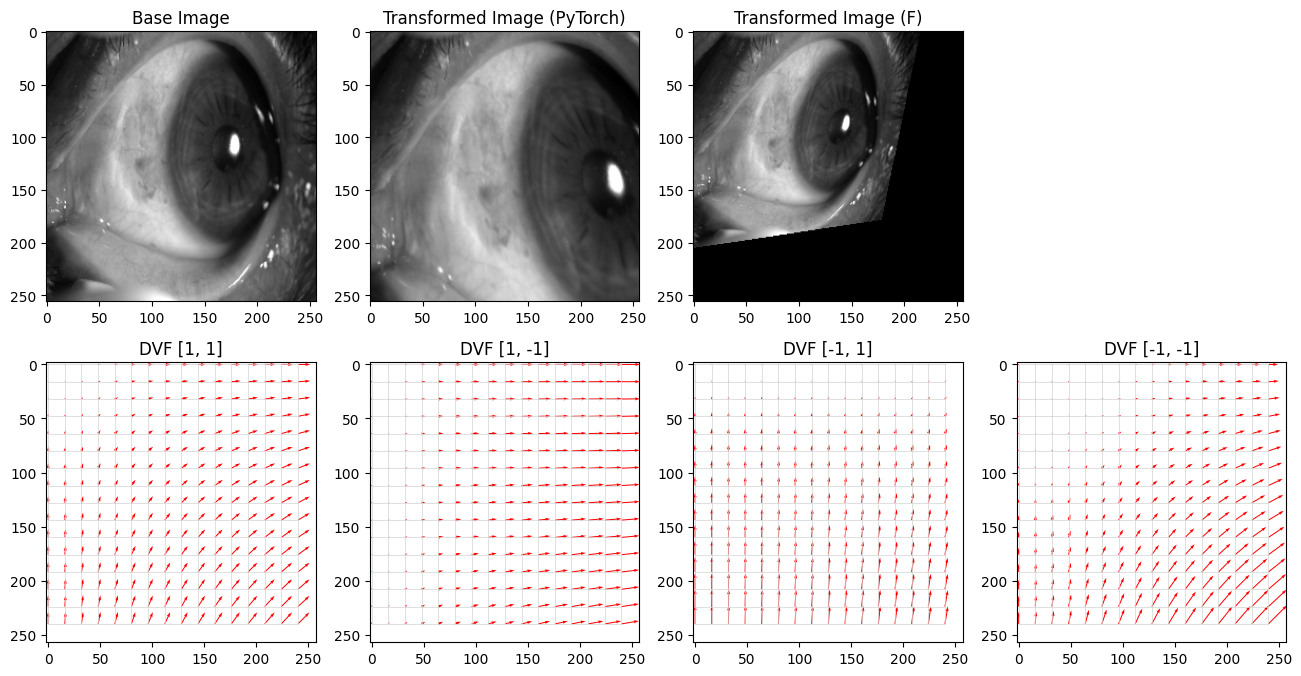

(256, 103) (256, 71)
torch.Size([2, 51, 1]) torch.Size([256, 256, 2])
DVF shape: (256, 256, 2), points shape: (2, 51, 1)
[[ 52.]
 [179.]]
[[151.]
 [ 89.]]
[[64.]
 [42.]]
[[85.]
 [10.]]
[[174.]
 [163.]]
[[169.]
 [ 59.]]
[[179.]
 [ 62.]]
[[68.]
 [21.]]
[[140.]
 [ 79.]]
[[121.]
 [ 12.]]
[[166.]
 [ 79.]]
[[168.]
 [134.]]
[[62.]
 [32.]]
[[ 10.]
 [158.]]
[[44.]
 [24.]]
[[ 78.]
 [112.]]
[[ 84.]
 [125.]]
[[52.]
 [41.]]
[[149.]
 [ 98.]]
[[184.]
 [ 48.]]
[[  9.]
 [130.]]
[[75.]
 [70.]]
[[157.]
 [118.]]
[[155.]
 [141.]]
[[100.]
 [158.]]
[[182.]
 [ 81.]]
[[ 84.]
 [164.]]
[[  8.]
 [185.]]
[[178.]
 [ 99.]]
[[ 10.]
 [170.]]
[[159.]
 [ 96.]]
[[177.]
 [114.]]
[[ 55.]
 [189.]]
[[67.]
 [90.]]
[[ 21.]
 [190.]]
[[49.]
 [75.]]
[[79.]
 [42.]]
[[ 32.]
 [171.]]
[[ 71.]
 [147.]]
[[ 61.]
 [113.]]
[[30.]
 [72.]]
[[149.]
 [150.]]
[[171.]
 [127.]]
[[180.]
 [ 14.]]
[[57.]
 [56.]]
[[89.]
 [44.]]
[[177.]
 [107.]]
[[160.]
 [ 58.]]
[[104.]
 [149.]]
[[47.]
 [56.]]
[[63.]
 [58.]]


RuntimeError: expand(torch.DoubleTensor{[2, 51, 1]}, size=[2, 51]): the number of sizes provided (2) must be greater or equal to the number of dimensions in the tensor (3)

In [171]:
# Define parameters
output_dir = "Dataset/synth_eye_perspetive_easy"  # Output directory
os.makedirs(output_dir, exist_ok=True)

# plot_dir = "Dataset/synthetic_eye_dataset_train/plot"
# os.makedirs(plot_dir, exist_ok=True)

# generate synthetic images for each source training image
generate_affine_transformed_images_multiple(image_list,
    'Dataset/synth_eye_perspetive_easy.csv', output_dir, num_images=3, modify=False)

In [ ]:
# # Define parameters
# image_size = (512, 512)  # Size of the images
# output_dir = "Dataset/synthetic_eye_dataset_train_multiple"  # Output directory
# os.makedirs(output_dir, exist_ok=True)

# # plot_dir = "Dataset/synthetic_eye_dataset_train_multiple/plot"
# # os.makedirs(plot_dir, exist_ok=True)


# # generate synthetic images for each source training image
# generate_affine_transformed_images_multiple(image_list,'dataset_eye_synth_train_multiple.csv', output_dir, num_images=2, modify=True)

# Test dataset

In [ ]:
# do the same for the test images
df_test = df[df['training'] == 1]
df_test['image_path'] = df_test['Directory'] + '/' + df_test['source']
image_list_test = df_test['image_path'].unique()[:50]

# Define parameters
output_dir = "Dataset/synth_eye_mix_test"  # Output directory
os.makedirs(output_dir, exist_ok=True)

# plot_dir = "Dataset/synthetic_eye_dataset_test/plot"
# os.makedirs(plot_dir, exist_ok=True)

# generate synthetic images for each source test image
generate_affine_transformed_images_multiple(image_list_test, 'Dataset/synth_eye_mix_test.csv', 
                                            output_dir, df_test_csv, num_images=2)



/tmp/ipykernel_12187/686737539.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['image_path'] = df_test['Directory'] + '/' + df_test['source']



Generated 100 images


In [ ]:
# # Define parameters
# image_size = (512, 512)  # Size of the images
# output_dir = "Dataset/synthetic_eye_dataset_test_multiple"  # Output directory
# os.makedirs(output_dir, exist_ok=True)

# # plot_dir = "Dataset/synthetic_eye_dataset_test/plot"
# # os.makedirs(plot_dir, exist_ok=True)

# # generate synthetic images for each source test image
# generate_affine_transformed_images_multiple(image_list_test, 'dataset_eye_synth_test_scaling.csv', output_dir, num_images=1)